The first thing we need to do is to download the dataset from Kaggle. We use the [Enron dataset](https://www.kaggle.com/wcukierski/enron-email-dataset), which is the biggest public email dataset available.
To do so we will use GDrive and download the dataset within a Drive folder to be used by Colab.

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
cd drive/MyDrive/Smart\ Compose


[Errno 2] No such file or directory: 'drive/MyDrive/Smart Compose'
/content/drive/MyDrive/Smart Compose


We can download the dataset from Kaggle and save it in the GDrive folder. This needs to be done only the first time.

In [ ]:
# !kaggle datasets download -d wcukierski/enron-email-dataset

# unzipping the zip files
# !unzip \*.zip

Now we are finally ready to start working with the dataset, accessible as a CSV file called `emails.csv`.

In [62]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import email
import re

In [63]:
emails_df = pd.read_csv('emails.csv')

In [64]:
# Use only a subpart of the whole dataset to avoid exceeding RAM
# emails_df = emails_df[:10000]

In [65]:
print(emails_df.shape)
emails_df.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,"Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: tim.belden@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Tim Belden <Tim Belden/Enron@EnronXGate>\nX-cc: \nX-bcc: \nX-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nHere is our forecast\n\n"
1,allen-p/_sent_mail/10.,"Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>\nDate: Fri, 4 May 2001 13:51:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: john.lavorato@enron.com\nSubject: Re:\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>\nX-cc: \nX-bcc: \nX-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nTraveling to have a business meeting takes the fun out of the trip. Especially if you have to prepare a presentation. I would suggest holding the business plan meetings here then take a trip without any formal business meetings. I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not. Too often the presenter speaks and the others are quiet just waiting for their turn. The meetings might be better if held in a round table discussion format. \n\nMy suggestion for where to go is Austin. Play golf and rent a ski boat and jet ski's. Flying somewhere takes too much time.\n"
2,allen-p/_sent_mail/100.,"Message-ID: <24216240.1075855687451.JavaMail.evans@thyme>\nDate: Wed, 18 Oct 2000 03:00:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: leah.arsdall@enron.com\nSubject: Re: test\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Leah Van Arsdall\nX-cc: \nX-bcc: \nX-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail\nX-Origin: Allen-P\nX-FileName: pallen.nsf\n\ntest successful. way to go!!!"
3,allen-p/_sent_mail/1000.,"Message-ID: <13505866.1075863688222.JavaMail.evans@thyme>\nDate: Mon, 23 Oct 2000 06:13:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: randall.gay@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Randall L Gay\nX-cc: \nX-bcc: \nX-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail\nX-Origin: Allen-P\nX-FileName: pallen.nsf\n\nRandy,\n\n Can you send me a schedule of the salary and level of everyone in the \nscheduling group. Plus your thoughts on any changes that need to be made. \n(Patti S for example)\n\nPhillip"
4,allen-p/_sent_mail/1001.,"Message-ID: <30922949.1075863688243.JavaMail.evans@thyme>\nDate: Thu, 31 Aug 2000 05:07:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: greg.piper@enron.com\nSubject: Re: Hello\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Greg Piper\nX-cc: \nX-bcc: \nX-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail\nX-Origin: Allen-P\nX-FileName: pallen.nsf\n\nLet's shoot for Tuesday at 11:45."


## We are intersted only in the message part

In [66]:
print(emails_df['message'][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


## Email Parsing
- Refer : https://towardsdatascience.com/how-i-used-machine-learning-to-classify-emails-and-turn-them-into-insights-efed37c1e66

In [67]:
# Convert to message objects from the message strings
messages = list(map(email.message_from_string, emails_df['message']))

In [68]:
def get_text_from_email(msg):
  parts = []
  for part in msg.walk():
      if part.get_content_type() == 'text/plain':
          parts.append( part.get_payload() )
  text = ''.join(parts)
  return text

emails = pd.DataFrame()

# Parse content from emails
emails['content'] = list(map(get_text_from_email, messages))

In [69]:
import gc

# Remove variables from memory
del messages
del emails_df
gc.collect()

147

## Simple text preprocessing

In [70]:
def normalize_text(text):
  text = text.lower()
  
  # creating a space between a word and the punctuation following it to separate words
  # and compact repetition of punctuation
  # eg: "he is a boy.." => "he is a boy ."
  text = re.sub(r'([.,!?]+)', r" \1 ", text)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
  text = re.sub(r"[^a-zA-Z?.!,']+", " ", text)

  # Compact spaces
  text = re.sub(r'[" "]+', " ", text)

  # Remove forwarded messages
  text = text.split('forwarded by')[0]

  text = text.strip()

  return text

emails['content'] = list(map(normalize_text, emails['content']))

## Handling Null Values

In [71]:
# Drop samples with empty content text after normalization
emails['content'].replace('', np.nan, inplace=True)
emails.dropna(subset=['content'], inplace=True)

In [72]:
pd.set_option('max_colwidth', -1)
emails.head(50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,content
0,here is our forecast
1,"traveling to have a business meeting takes the fun out of the trip . especially if you have to prepare a presentation . i would suggest holding the business plan meetings here then take a trip without any formal business meetings . i would even try and get some honest opinions on whether a trip is even desired or necessary . as far as the business meetings , i think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not . too often the presenter speaks and the others are quiet just waiting for their turn . the meetings might be better if held in a round table discussion format . my suggestion for where to go is austin . play golf and rent a ski boat and jet ski's . flying somewhere takes too much time ."
2,test successful . way to go !!!
3,"randy , can you send me a schedule of the salary and level of everyone in the scheduling group . plus your thoughts on any changes that need to be made . patti s for example phillip"
4,let's shoot for tuesday at .
5,"greg , how about either next tuesday or thursday ? phillip"
6,please cc the following distribution list with updates phillip allen pallen enron . com mike grigsby mike . grigsby enron . com keith holst kholst enron . com monique sanchez frank ermis john lavorato thank you for your help phillip allen
7,any morning between and
8,. login pallen pw ke davis i don't think these are required by the isp . static ip address ip . . . sub . . . gate . . . dns . . . . company rc
10,"mr . buckner , for delivered gas behind san diego , enron energy services is the appropriate enron entity . i have forwarded your request to zarin imam at ees . her phone number is . phillip allen"


## Since are we only interested in message body , so we will choose and work only on that feature.

- After character level data preparation and applying __teacher forcing__ concept it would make the data huge.

### TEACHER FORCE TECHNIQUE

- There are sequence prediction models that use the output from the last time step y(t-1) as input for the model at the current time step X(t).

For instance, the sentence `here is our forecast` is split in the following pairs within the dataset:

```
[
  ('<start> here is <end>', '<start> our forecast <end>'),
  ('<start> here is our <end>', '<start> forecast <end>')
]
```

- - Preprocessing the captions (adding '< start >' and '< end >' tags to every caption), so that out ML model understands the starting and ending of each caption.

In [74]:
# Skip long sentences, which increase maximum length a lot when padding
# and make the number of parameters to train explode
SENTENCE_MAX_WORDS = 20

def generate_dataset (emails):
  contents = emails['content']
  output = []
  vocabulary_sentences = []

  for content in contents:
    # Skip emails longer than one sentence
    if (len(content) > SENTENCE_MAX_WORDS * 5): #100 words limit
        continue

    sentences = content.split(' . ')
    for sentence in sentences:
      # Remove user names from start or end of sentence. This is just an heuristic
      # but it's more efficient than compiling the list of names and removing all of them
      sentence = re.sub("(^\w+\s,\s)|(\s,\s\w+$)", "", sentence)
      words = sentence.split(' ')

      if ((len(words) > SENTENCE_MAX_WORDS) or (len(words) < 2)):
        continue

      vocabulary_sentences.append('<start> ' + sentence + ' <end>')

      for i in range(1, len(words) - 1):
        input_data = '<start> ' + ' '.join(words[:i+1]) + ' <end>'
        output_data = '<start> ' + ' '.join(words[i+1:]) + ' <end>'
        data = (input_data, output_data)
        output.append(data)

  return output, vocabulary_sentences

pairs, vocabulary_sentences = generate_dataset(emails)

In [75]:
print(len(pairs))
print(len(vocabulary_sentences))
print(*pairs[:10], sep='\n')
print(*vocabulary_sentences[:10], sep='\n')

509918
104151
('<start> here is <end>', '<start> our forecast <end>')
('<start> here is our <end>', '<start> forecast <end>')
('<start> way to <end>', '<start> go !!! <end>')
('<start> way to go <end>', '<start> !!! <end>')
("<start> let's shoot <end>", '<start> for tuesday at . <end>')
("<start> let's shoot for <end>", '<start> tuesday at . <end>')
("<start> let's shoot for tuesday <end>", '<start> at . <end>')
("<start> let's shoot for tuesday at <end>", '<start> . <end>')
('<start> how about <end>', '<start> either next tuesday or thursday ? phillip <end>')
('<start> how about either <end>', '<start> next tuesday or thursday ? phillip <end>')
<start> here is our forecast <end>
<start> test successful <end>
<start> way to go !!! <end>
<start> let's shoot for tuesday at . <end>
<start> how about either next tuesday or thursday ? phillip <end>
<start> any morning between and <end>
<start> million is fine phillip <end>
<start> i think fletch has a good cpa <end>
<start> i am still doing

## Tokenisaton
1. First, we will tokenize the emails. This will help us to build a vocabulary of all the unique words in the data. We also limit to the 10k most frequent words, deleting uncommon words from sentences.
2. Next, We will replace all the other words with the token < unk > (for words not in vocabulary) . You , can obviously optimize that according to the use cases.
3. Finally, we will create a word->index mapping and vice versa.
4. We will pad all sequences to be the same length as the longest one.

### Normally we would use two tokenizers, one for the input strings and a different one for the output text, but in this case we are predicting the same vocabulary in both cases. All the words in the output texts are available also in the input texts because of how dataset pairs are generated.

### Also since we will apply the "teacher forcing" technique during training, we need both the target data and the (target + 1 timestep) data.

In [76]:
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)

In [77]:
vocab_max_size = 10000

def tokenize(text):
  tokenizer = keras.preprocessing.text.Tokenizer(filters='', num_words=vocab_max_size)
  tokenizer.fit_on_texts(text)

  return tokenizer

input = [pair[0] for pair in pairs]
output = [pair[1] for pair in pairs]
tokenizer = tokenize(vocabulary_sentences)

encoder_input = tokenizer.texts_to_sequences(input)
decoder_input = tokenizer.texts_to_sequences(output)

decoder_target = [
  [decoder_input[seqN][tokenI + 1]
   for tokenI in range(len(decoder_input[seqN]) - 1)]
    for seqN in range(len(decoder_input))]

# Convert to np.array
encoder_input = np.array(encoder_input)
decoder_input = np.array(decoder_input)
decoder_target = np.array(decoder_target)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Train-Test Split (80:20%)

In [78]:
from sklearn.model_selection import train_test_split

encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(encoder_input, decoder_input, decoder_target, test_size=0.2)

In [79]:
print(encoder_input_train.shape, encoder_input_test.shape)
print(decoder_input_train.shape, decoder_input_test.shape)
print(decoder_target_train.shape, decoder_target_test.shape)

(407934,) (101984,)
(407934,) (101984,)
(407934,) (101984,)


## Padding after tokenisation

In [ ]:
def max_length(t):
    return max(len(i) for i in t)

max_length_in = max_length(encoder_input)
max_length_out = max_length(decoder_input)

encoder_input_train = keras.preprocessing.sequence.pad_sequences(encoder_input_train, maxlen=max_length_in, padding="post")
decoder_input_train = keras.preprocessing.sequence.pad_sequences(decoder_input_train, maxlen=max_length_out, padding="post")
decoder_target_train = keras.preprocessing.sequence.pad_sequences(decoder_target_train, maxlen=max_length_out, padding="post")

encoder_input_test = keras.preprocessing.sequence.pad_sequences(encoder_input_test, maxlen=max_length_in, padding="post")
decoder_input_test = keras.preprocessing.sequence.pad_sequences(decoder_input_test, maxlen=max_length_out, padding="post")
decoder_target_test = keras.preprocessing.sequence.pad_sequences(decoder_target_test, maxlen=max_length_out, padding="post")

In [ ]:
print(max_length_in, max_length_out)

21 20


In [ ]:
# Shuffle the data in unison
p = np.random.permutation(len(encoder_input_train))
encoder_input_train = encoder_input_train[p]
decoder_input_train = decoder_input_train[p]
decoder_target_train = decoder_target_train[p]

q = np.random.permutation(len(encoder_input_test))
encoder_input_test = encoder_input_test[q]
decoder_input_test = decoder_input_test[q]
decoder_target_test = decoder_target_test[q]

### Rule of thumb of embedding size: vocab_size ** 0.25
- https://stackoverflow.com/questions/48479915/what-is-the-preferred-ratio-between-the-vocabulary-size-and-embedding-dimension

In [80]:
import math

batch_size = 128
vocab_size = vocab_max_size if len(tokenizer.word_index) > vocab_max_size else len(tokenizer.word_index)
# Rule of thumb of embedding size: vocab_size ** 0.25
# https://stackoverflow.com/questions/48479915/what-is-the-preferred-ratio-between-the-vocabulary-size-and-embedding-dimension
embedding_dim = math.ceil(vocab_size ** 0.25)
latent_dim = 192 # Latent dimensionality of the encoding space.

In [81]:
print(vocab_size, embedding_dim)

10000 10


## Training

Here we define the RNN models. We start with the Encoder-Decoder model used in training which leverages the "teacher forcing technique". Therefore, it will receive as input `encoder_input` and `decoder_input` datasets.

Then the second model is represented by the inference Decoder which will receive as input the encoded states of the input sequence and the predicted token of the previous time step.

Both models use GRU units to preserve the context state, which have been shown to be more accurate than LSTM units and simpler to use since they have only one state.

## Defining the ENCODER and DECODER Neural Network

1. Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

2. Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

3. Initial State: This is used to initialize the internal states of the LSTM for the first timestep

In [ ]:
# GRU Encoder
encoder_in_layer = keras.layers.Input(shape=(max_length_in,))
encoder_embedding = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
encoder_bi_gru = keras.layers.Bidirectional(keras.layers.GRU(units=latent_dim, return_sequences=True, return_state=True))

# Discard the encoder output and use hidden states (h) and memory cells states (c)
# for forward (f) and backward (b) layer
encoder_out, fstate_h, bstate_h = encoder_bi_gru(encoder_embedding(encoder_in_layer))
state_h = keras.layers.Concatenate()([fstate_h, bstate_h])





# GRUDecoder
decoder_in_layer = keras.layers.Input(shape=(None,))
decoder_embedding = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
decoder_gru = keras.layers.GRU(units=latent_dim * 2, return_sequences=True, return_state=True)
# Discard internal states in training, keep only the output sequence
decoder_gru_out, _ = decoder_gru(decoder_embedding(decoder_in_layer), initial_state=state_h)
decoder_dense_1 = keras.layers.Dense(128, activation="relu")
decoder_dense = keras.layers.Dense(vocab_size, activation="softmax")
decoder_out_layer = decoder_dense(keras.layers.Dropout(rate=0.2)(decoder_dense_1(keras.layers.Dropout(rate=0.2)(decoder_gru_out))))




# Define the model that uses the Encoder and the Decoder
model = keras.models.Model([encoder_in_layer, decoder_in_layer], decoder_out_layer)

def perplexity(y_true, y_pred):
    return keras.backend.exp(keras.backend.mean(keras.backend.sparse_categorical_crossentropy(y_true, y_pred)))

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=[perplexity])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 21, 10)       100000      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 21, 384), (N 235008      embedding[0][0]                  
______________________________________________________________________________________________

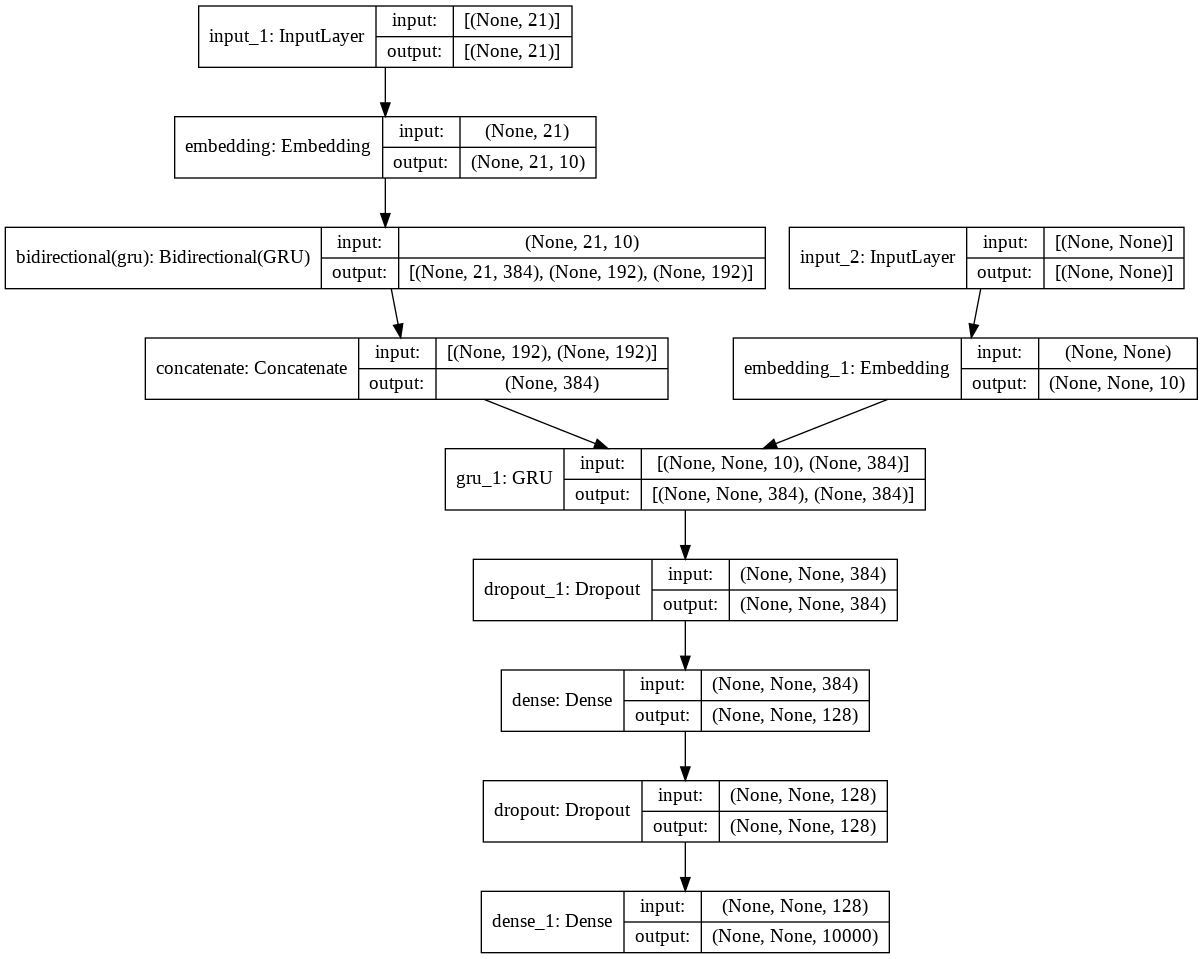

In [ ]:
keras.utils.plot_model(model, "encoder-decoder.png", show_shapes=True)

In [ ]:
epochs = 10
history = model.fit([encoder_input_train, decoder_input_train], decoder_target_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.2)

def plot_history(history):
  plt.plot(history.history['loss'], label="Training loss")
  plt.plot(history.history['val_loss'], label="Validation loss")
  plt.legend()

plot_history(history)

Epoch 1/10
2550/2550 [==============================] - 187s 69ms/step - loss: 1.6050 - perplexity: 43.2945 - val_loss: 1.3387 - val_perplexity: 3.8282
Epoch 2/10
2550/2550 [==============================] - 176s 69ms/step - loss: 1.2482 - perplexity: 3.5031 - val_loss: 1.1005 - val_perplexity: 3.0139
Epoch 3/10
2550/2550 [==============================] - 177s 69ms/step - loss: 1.0663 - perplexity: 2.9146 - val_loss: 0.9396 - val_perplexity: 2.5641
Epoch 4/10
2550/2550 [==============================] - 176s 69ms/step - loss: 0.9465 - perplexity: 2.5828 - val_loss: 0.8353 - val_perplexity: 2.3094
Epoch 5/10
2550/2550 [==============================] - 176s 69ms/step - loss: 0.8683 - perplexity: 2.3875 - val_loss: 0.7683 - val_perplexity: 2.1592
Epoch 6/10
2550/2550 [==============================] - 175s 68ms/step - loss: 0.8148 - perplexity: 2.2628 - val_loss: 0.7195 - val_perplexity: 2.0562
Epoch 7/10
2550/2550 [==============================] - 174s 68ms/step - loss: 0.7762 - perpl

In [ ]:
scores = model.evaluate([encoder_input_test[:1000], decoder_input_test[:1000]], decoder_target_test[:1000])
print("%s: %.2f" % (model.metrics_names[1], scores[1]))

32/32 [==============================] - 1s 19ms/step - loss: 0.6208 - perplexity: 1.8614
perplexity: 1.86


In [ ]:
# Inference Decoder
encoder_model = keras.models.Model(encoder_in_layer, state_h)

state_input_h = keras.layers.Input(shape=(latent_dim * 2,))
inf_decoder_out, decoder_h = decoder_gru(decoder_embedding(decoder_in_layer), initial_state=state_input_h)
inf_decoder_out = decoder_dense(decoder_dense_1(inf_decoder_out))
inf_model = keras.models.Model(inputs=[decoder_in_layer, state_input_h], 
                  outputs=[inf_decoder_out, decoder_h])

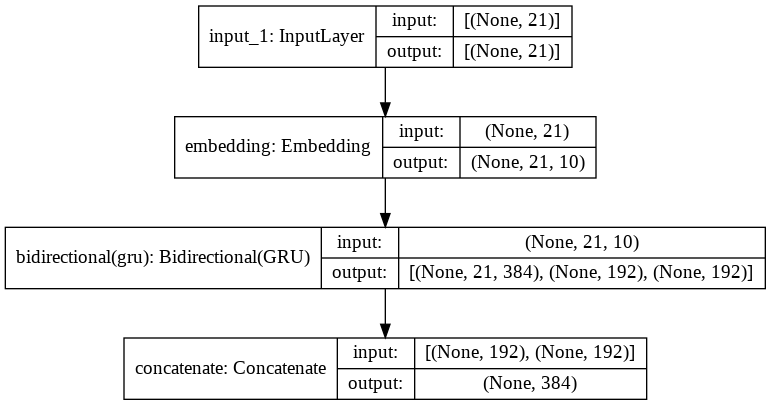

In [ ]:
keras.utils.plot_model(encoder_model, "encoder-model.png", show_shapes=True)

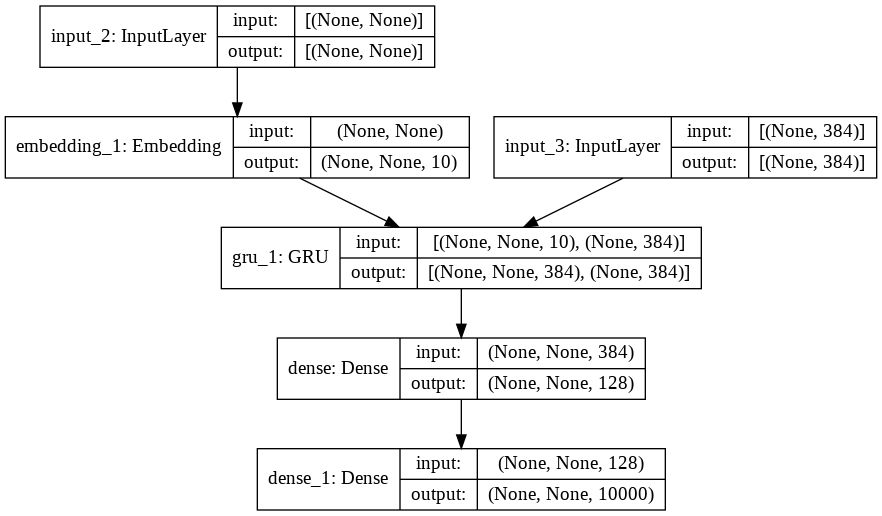

In [ ]:
keras.utils.plot_model(inf_model, "inference-model.png", show_shapes=True)

In [ ]:
def tokenize_text(text):
  text = '<start> ' + text.lower() + ' <end>'
  text_tensor = tokenizer.texts_to_sequences([text])
  text_tensor = keras.preprocessing.sequence.pad_sequences(text_tensor, maxlen=max_length_in, padding="post")
  return text_tensor

# Reversed map from a tokenizer index to a word
index_to_word = dict(map(reversed, tokenizer.word_index.items()))

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
def decode_sequence(input_tensor):
    # Encode the input as state vectors.
    state = encoder_model.predict(input_tensor)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<start>']
    curr_word = "<start>"
    decoded_sentence = ''

    i = 0
    while curr_word != "<end>" and i < (max_length_out - 1):
        output_tokens, h = inf_model.predict([target_seq, state])

        curr_token = np.argmax(output_tokens[0, 0])

        if (curr_token == 0):
          break;

        curr_word = index_to_word[curr_token]

        decoded_sentence += ' ' + curr_word
        target_seq[0, 0] = curr_token
        state = h
        i += 1

    return decoded_sentence

In [ ]:
def tokens_to_seq(tokens):
  words = list(map(lambda token: index_to_word[token] if token != 0 else '', tokens))
  return ' '.join(words)

Let's test the inference model with some inputs.

In [ ]:
texts = [
    'here is',
    'have a',
    'please review',
    'please call me',
    'thanks for',
    'let me',
    'Let me know',
    'Let me know if you',
    'this sounds',
    'is this call going to',
    'can you get',
    'is it okay',
    'it should',
    'call if there\'s',
    'gave her a',
    'i will let',
    'i will be',
    'may i get a copy of all the',
    'how is our trade',
    'this looks like a',
    'i am fine with the changes',
    'please be sure this'
]

output = list(map(lambda text: (text, decode_sequence(tokenize_text(text))), texts))
output_df = pd.DataFrame(output, columns=["input", "output"])
output_df.head(len(output))

,input,output
0,here is,the latest version . <end>
1,have a,great weekend <end>
2,please review,the attached outage report <end>
3,please call me,if you have any questions . <end>
4,thanks for,the heads up <end>
5,let me,know if you have any questions . <end>
6,Let me know,if you have any questions . <end>
7,Let me know if you,have any questions . <end>
8,this sounds,fine <end>
9,is this call going to,go to the game tonight ? <end>


The predicted outputs are actually quite good. The grammar is correct and have a logical sense. Some predictions also show that the predictions are personalized based on the Enron dataset, for instance in the case of `here is - the latest version of the presentation`.
The `please review - the attached outage report` also shows personalized prediction. This is consistent with the goal the task.

Save the Tokenizer and the Keras model for usage within the browser.

In [ ]:
import json 

with open( 'word_dict-final.json' , 'w' ) as file:    
    json.dump( tokenizer.word_index , file)

In [ ]:
encoder_model.save('./encoder-model-final.h5')
inf_model.save('./inf-model-final.h5')